In [1]:
import numpy as np
from scipy.sparse import diags, linalg
import matplotlib.pyplot as plt

%matplotlib inline

Many computation problems boil down to solving systems of linear equations.  Consider the system,

\begin{array}{lllll}
2x_1 & +3x_2 & -x_3 & = & 6\\
-4x_1 &   & x_3 & = & 7\\
      & x_2 &  -2x_3 & = & 1
\end{array}

We can write the above system in matrix form as:
$$\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)
\left(
\begin{array}{c}
x_1 \\
x_2 \\
x_3
\end{array}
\right) = \left(
\begin{array}{c}
6 \\
7 \\ 1
\end{array}
\right)
$$

Then we can use Numpy's/Scipy's linear algebra function to find the inverse of the square matrix.  If we Multiply though by the inverse we get,
$$\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)
\left(
\begin{array}{c}
x_1 \\
x_2 \\
x_3
\end{array}
\right) = 
\left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
6 \\
7 \\ 1
\end{array}
\right)
$$

Which becomes,

$$
\left(
\begin{matrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 
\end{matrix}
\right)
\left(
\begin{array}{c}
x \\
y\\
z
\end{array}
\right) = \left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
6 \\
7 \\
1 
\end{array}
\right)
$$

which gives our solution,
$$
\left(
\begin{array}{c}
x \\
y\\
z
\end{array}
\right) = \left(
\begin{matrix}
2 & 3 & -1 \\
-4 & 0 & 1 \\
0 & 1 & -2
\end{matrix}
\right)^{-1}
\left(
\begin{array}{c}
6 \\
7 \\
1 
\end{array}
\right)
$$

While Numpy has a command <i>np.linalg.inv</i> to find the matrix inverse, we can solve the whole system with one line of code using <np.linalg.solve</i>.

Let's solve the above system.

In [2]:
#  Define our coefficient matrix and our vector of knowns.
A = np.array( [[2, 3, -1], [-4, 0, 1], [0, 1, -2] ])
Y = np.array( [6, 7, 1])

#  Calculate and multiply though by the matrix inverse to get the solution.
Ainv = np.linalg.inv(A)
X = np.matmul(Ainv, Y)

print(X)
x1 = X[0]
x2 = X[1]
x3 = X[2]

#  Test to see if our solution works.
print(  2 * x1 + 3 * x2 - x3)
print( np.matmul(A, X))

#  We can do the same thing with a single line using the solve function.
print( np.linalg.solve(A, Y) )

[-1.45454545  3.36363636  1.18181818]
5.999999999999999
[6. 7. 1.]
[-1.45454545  3.36363636  1.18181818]


##  Stock Simulator

In a previous video, we used  Monte Carlo techniques to simulate the behavior of a stock.  Our model was,

\begin{equation}
\frac{S_{i+1} - S_i}{S_i} = r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i. 
\end{equation}

Which can be written as:
\begin{equation}
S_{i+1} = S_i \left(r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i\right) + S_i
\end{equation}

We can iterate with a for loop to get the price at each day:

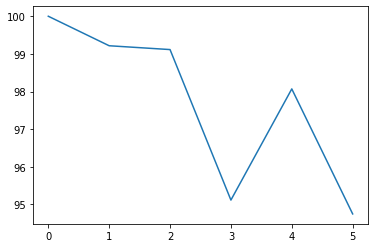

In [3]:
#  Set a constant seed to keep our different pieces of test code the same
np.random.seed(2)

#  Number of days in the simulation and the starting price of the stock.
N_days = 5
S = 100

#  Define the risk-free rate, volatility and time step in days
r = 0.01 / 252.0
sigma = 0.3 / np.sqrt(252)
dt = 1.0

#  Sample numbers from the normal distribution for our Monte Carlo simulation
epsilon = np.random.normal( size = N_days )

#  Create a list to store our results and append the initial stock price to it.
S_data = []
S_data.append(S)

#  Do the iteration using the formula above
for i in range(N_days):
    S = S * ( r * dt + np.sqrt(dt) * sigma * epsilon[i] ) + S
    S_data.append(S)

#  Plot the results
plt.plot(S_data)

While the above works fine, there are computationally more efficient ways to do this.  If one wanted to do, for example, real-time Monte Carlo simulation of dozens of stocks using 10,000 runs per simulation, the above code may not work so well.

But note how we can write our model as a system of linear equations.

Our original equation
\begin{equation}
S_{i+1} = S_i \left(r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i\right) + S_i
\end{equation}
To simplify notation,
$$r\Delta t + \sqrt{\Delta t}\sigma \epsilon_i = \Lambda_i.$$
Which gives,
$$
S_{i+1} = S_i \Lambda_i + S_i
$$
Explicitly writing out the iterations,
\begin{equation}\begin{array}{lcl}S_0                     & = & S_0 \\S_1 - S_0 \Lambda_1 - S_0 & = &  0\\\S_2 - S_1 \Lambda_2 - S_1 & = & 0 \\S_3 - S_2 \Lambda_3 - S_2 & = & 0 \\& \vdots & \\S_i - _{i-} \Lambda_i - S_{i-1} & = & 0 .\\\end{array}\label{unrolled}\end{equation}
In matrix form,
\begin{equation} \left( \begin{matrix} 1 & 0 & 0 & 0 & \cdots & 0 \\ \Lambda_1 + 1 & -1 & 0 & 0 & \cdots & 0 \\ 0 & \Lambda_2 + 1 & -1 & 0 & \cdots & 0 \\ 0 & 0 & \Lambda_3 + 1 & -1 & \cdots & 0 \\ \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\ 0 & 0 & 0 & 0 & \Lambda_5 + 1 & -1 \end{matrix} \right) \left( \begin{array}{c} S_0 \\ S_1 \\ S_2 \\ S_3 \\ \vdots \\ S_i \\ \end{array} \right) = \left( \begin{array}{c} S_0 \\ 0 \\ 0 \\ 0 \\ \vdots \\ 0 \\ \end{array} \right). \label{simple_matrix} \end{equation}

Note also, the the above matrix is "sparse" meaning that almost all eintries are zero.  In many cases, we can take advantage of sparse matrix algorithms which can calculate the inverse quicker than if the matrix were dense.  Furthermore, since most entries are zero, we can save memory by only storing the non-zero entries along with their position in the matrix.

Let's repeat the above calculation using the sparse matrix libraies from <i>scipy.sparse</i>.

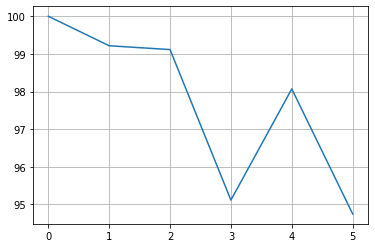

In [4]:
#  Reset the random seed
np.random.seed(2)

#  Define the stock price initially, the number of days, the interest rate and volatility
N_days = 5

S0 = 100.0
r = 0.01 / 252
dt = 1.0
sigma = 0.3 / np.sqrt(252)

#  For the diags command, we need to define the entries on the diagonals.
Lambda = r * dt + np.sqrt(dt) * sigma * epsilon
ones = -np.ones( N_days + 1); ones[0] = 1
L = Lambda + 1

#  Build the matrix
M = diags([L, ones], [-1, 0], format = 'csc')
Y = np.zeros( N_days + 1); Y[0] = S0

#  Solve the system
S = linalg.spsolve(M, Y)
plt.plot(S)
plt.grid(True)

In [5]:
#  Compare the results of the two methods to make sure they are the same.
print(S_data)
print(S)
np.allclose(S_data, S)

[100, 99.21636995313291, 99.11480606975978, 95.11744359403632, 98.06968807185457, 94.74972862038193]
[100.          99.21636995  99.11480607  95.11744359  98.06968807
  94.74972862]


True